# Spectral Bias Analysis using Trace Jacobian of PINN Loss Terms for Klein-Gordon


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import gc
import numpy as np
from matplotlib import pyplot as plt

Import local packages

In [3]:
from src.utils.logger import Logging
from src.utils.color import model_color
from src.utils.plot_eigenvalues import plot_ntk_eigenvalues

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.

In [4]:
TEST_CHECKPOINT_PATH = os.path.join("result/klein")
logger = Logging(TEST_CHECKPOINT_PATH)
result_dir = logger.get_output_dir()
print(f"{result_dir=}")

result_dir='result/klein/2025-06-02_18-07-32-558084'


In [5]:
# # fourier
# python -m src.trainer.main_trainer --total_epochs 60000  --save_every 1000 --print_every 1000 --batch_size 128 --log_path ./checkpoints --solver fourier --problem klein_gordon  --weights  "[50.0, 50.0, 1.0]" --network "[2, 30, 30, 30, 1]"

# # bspline
#  python -m src.trainer.main_trainer --total_epochs 60000  --save_every 1000 --print_every 1000 --batch_size 128 --log_path ./checkpoints --solver bspline --problem klein_gordon  --weights  "[50.0, 50.0, 1.0]" --network "[2, 30, 30, 30, 1]"

# # tanh
# python -m src.trainer.main_trainer --total_epochs 60000  --save_every 1000 --print_every 1000 --batch_size 128 --log_path ./checkpoints --solver tanh --problem klein_gordon  --weights  "[50.0, 50.0, 1.0]" --network "[2, 30, 30, 30, 1]"

# # param_tanh
# python -m src.trainer.main_trainer --total_epochs 60000  --save_every 1000 --print_every 1000 --batch_size 128 --log_path ./checkpoints --solver param_tanh --problem klein_gordon  --weights  "[50.0, 50.0, 1.0]" --network "[2, 30, 30, 30, 1]"

# # grbf
# python -m src.trainer.main_trainer --total_epochs 60000  --save_every 1000 --print_every 1000 --batch_size 128 --log_path ./checkpoints --solver grbf --problem klein_gordon  --weights  "[50.0, 50.0, 1.0]" --network "[2, 30, 30, 30, 1]"

# # chebyshev
# python -m src.trainer.main_trainer --total_epochs 60000  --save_every 1000 --print_every 1000 --batch_size 128 --log_path ./checkpoints --solver chebyshev --problem klein_gordon  --weights  "[50.0, 50.0, 1.0]" --network "[2, 30, 30, 30, 1]"

# # jacobi
# python -m src.trainer.main_trainer --total_epochs 60000  --save_every 1000 --print_every 1000 --batch_size 128 --log_path ./checkpoints --solver jacobi --problem klein_gordon  --weights  "[50.0, 50.0, 1.0]" --network "[2, 30, 30, 30, 1]"


In [6]:
TANH_NORM_DIST = "./checkpoints/2025-05-30_14-14-46-500859/model.pth"
TANH_PARAM_DIST = "./checkpoints/2025-05-30_14-15-45-045950/model.pth"
BSPLINE_DIST = "./checkpoints/2025-05-30_14-14-12-016582/model.pth"
GRBF_DIST = "./checkpoints/2025-05-30_14-17-39-499991/model.pth"
FOURIER_DIST = "./checkpoints/2025-05-30_14-13-21-301926/model.pth"
CHEBTSHEV_DIST = "./checkpoints/2025-05-30_14-18-48-636950/model.pth"
JACOBI_DIST = "./checkpoints/2025-05-30_14-20-09-948884/model.pth"


MODEL_PATH_LIST = {
    "tanh": TANH_NORM_DIST,
    "param_tanh": TANH_PARAM_DIST,
    "grbf": GRBF_DIST,
    "bspline": BSPLINE_DIST,
    "chebyshev": CHEBTSHEV_DIST,
    "jacobi": JACOBI_DIST,
    "fourier": FOURIER_DIST,
}

## Load the saved models

In [7]:
trace_jacobian_bc_log_dic = {}
trace_jacobian_res_log_dic = {}
trace_jacobian_ic_log_dic = {}

for model_name, model_path in MODEL_PATH_LIST.items():
    logger.print(f"MODEL_PATH {model_path}")
    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")
    trace_jacobian_bc_log = state.get("trace_jacobian_bc_log")
    trace_jacobian_res_log = state.get("trace_jacobian_res_log")
    trace_jacobian_ic_log = state.get("trace_jacobian_ic_log")
    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_dict = state.get("loss_history")

    logger.print(f"activation:  , {model_activation_name}")
    logger.print(f"problem: {config.get('problem')}")
    logger.print(f"solver:  , {solver}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")

    # logger.print(
    #     f"Model {model_name} with iterations: {len(loss_dict[next(iter(loss_dict))])}"
    # )

    trace_jacobian_bc_log_dic[model_name] = trace_jacobian_bc_log
    trace_jacobian_res_log_dic[model_name] = trace_jacobian_res_log
    trace_jacobian_ic_log_dic[model_name] = trace_jacobian_ic_log

    logger.print("******************************\n")
    gc.collect()
    torch.cuda.empty_cache()

logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:MODEL_PATH ./checkpoints/2025-05-30_14-14-46-500859/model.pth


INFO:src.utils.logger:activation:  , None
INFO:src.utils.logger:problem: klein_gordon
INFO:src.utils.logger:solver:  , tanh
INFO:src.utils.logger:network:  , [2, 30, 30, 30, 1]
INFO:src.utils.logger:term loss weights :  , [50.0, 50.0, 1.0]
INFO:src.utils.logger:******************************

INFO:src.utils.logger:MODEL_PATH ./checkpoints/2025-05-30_14-15-45-045950/model.pth
INFO:src.utils.logger:activation:  , None
INFO:src.utils.logger:problem: klein_gordon
INFO:src.utils.logger:solver:  , param_tanh
INFO:src.utils.logger:network:  , [2, 30, 30, 30, 1]
INFO:src.utils.logger:term loss weights :  , [50.0, 50.0, 1.0]
INFO:src.utils.logger:******************************

INFO:src.utils.logger:MODEL_PATH ./checkpoints/2025-05-30_14-17-39-499991/model.pth
INFO:src.utils.logger:activation:  , None
INFO:src.utils.logger:problem: klein_gordon
INFO:src.utils.logger:solver:  , grbf
INFO:src.utils.logger:network:  , [2, 30, 30, 30, 1]
INFO:src.utils.logger:term loss weights :  , [50.0, 50.0, 1.0

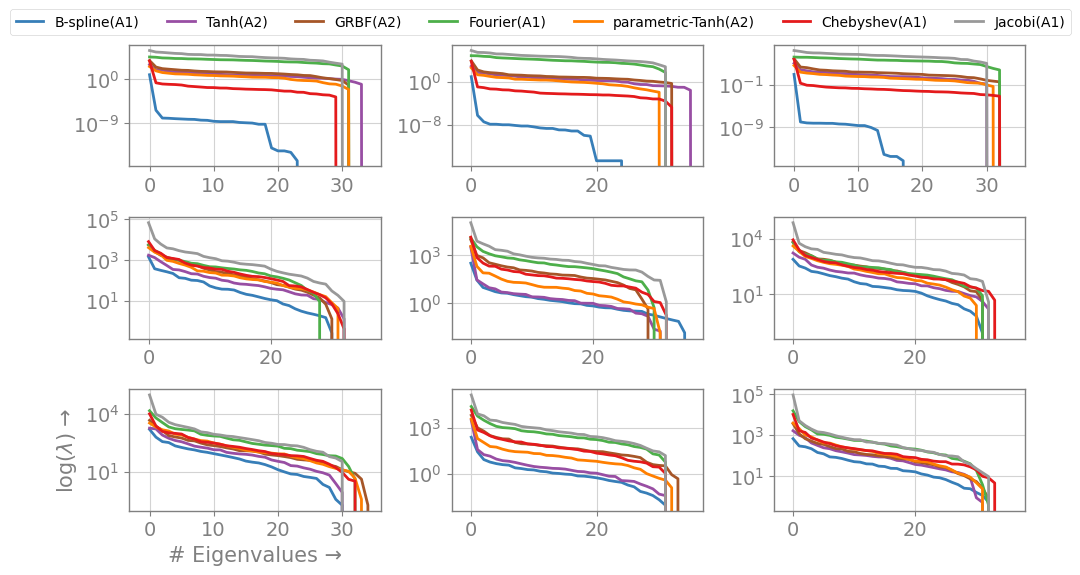

In [10]:
min_length = min(len(trace_jacobian_bc_log_dic[k]) for k in trace_jacobian_bc_log_dic)
time_iterations = [0, min_length // 2, min_length - 1]

dict_list = [
    trace_jacobian_bc_log_dic,
    trace_jacobian_ic_log_dic,
    trace_jacobian_res_log_dic,
]

rows = len(time_iterations)
cols = len(dict_list)

fig, ax = plt.subplots(rows, cols)
fig.set_size_inches([10, 5.5])

lines = []
labels = []

for row, time_iteration in enumerate(time_iterations):
    for col, dict_ in enumerate(dict_list):
        data_list = [
            {
                "data": dict_["bspline"][time_iteration],
                "color": model_color["bspline"],
                "name": "B-spline(A1)",
                "alpha": 1.0,
            },
            {
                "data": dict_["tanh"][time_iteration],
                "color": model_color["tanh"],
                "name": "Tanh(A2)",
                "alpha": 1.0,
            },
            {
                "data": dict_["grbf"][time_iteration],
                "color": model_color["grbf"],
                "name": "GRBF(A2)",
                "alpha": 1.0,
            },
            {
                "data": dict_["fourier"][time_iteration],
                "color": model_color["fourier"],
                "name": "Fourier(A1)",
                "alpha": 1.0,
            },
            {
                "data": dict_["param_tanh"][time_iteration],
                "color": model_color["param_tanh"],
                "name": "parametric-Tanh(A2)",
                "alpha": 1.0,
            },
            {
                "data": dict_["chebyshev"][time_iteration],
                "color": model_color["chebyshev"],
                "name": "Chebyshev(A1)",
                "alpha": 1.0,
            },
            {
                "data": dict_["jacobi"][time_iteration],
                "color": model_color["jacobi"],
                "name": "Jacobi(A1)",
                "alpha": 1.0,
            },
        ]

        plot_ntk_eigenvalues(ax[row, col], data_list, row=row, col=col)

for line in ax[-1, -1].get_lines():
    lines.append(line)
    labels.append(line.get_label())

save_path = os.path.join(logger.get_output_dir(), "ntk_eigenvalues_klein.png")

legend = fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=7
)
legend.get_frame().set_facecolor("white")

plt.tight_layout()
plt.savefig(save_path)